In [188]:
import re
import random
import pandas as pd
import hashlib

In [189]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.5) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [190]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Email Auth and Security,176.066179,44.016545,63.624650,4
Azure VM + Developer,191.091583,5.620341,14.199291,34
"Jane Eyre, Bronte",298.532563,37.316570,53.003938,8
TSQL,503.163071,20.965128,30.091575,24
Azure AD Authentication,745.354340,62.112862,137.083490,12
RAG Project,777.443584,86.382620,238.605613,9
Logging in Python,847.560095,60.540007,103.991061,14
Azure Private DNS,1412.636260,74.349277,147.047536,19
Azure Functions + PP365,1908.729202,90.891867,213.896490,21
C# Basics,1937.526193,62.500845,132.517701,31


# Histogram

sum of ages: ~46296.43


<Axes: >

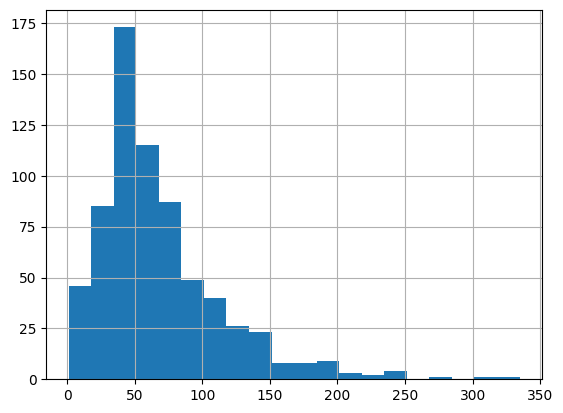

In [191]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~46296.43


<Axes: >

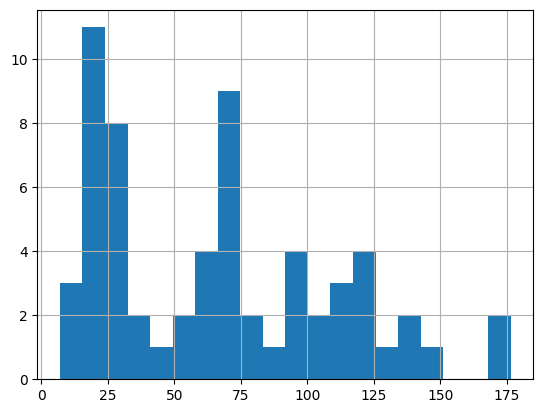

In [192]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Azure Developer Associate']['age'].hist(bins=20)

# Completely Random Shuffle

In [193]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [194]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [195]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

## Headers with greatest age sum first

In [196]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)
# existing_cards.head(10)

## Header with oldest cards first

In [197]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [198]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [199]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [200]:
n=3
m=existing_cards.shape[0]//100
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 681
Total card age: 46296.43


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
40,Azure Developer Associate,Let's say you use container images to run comp...,6c087cd1efc25fbc3d46c65296b5e8d9,-176.449246,66.881756,176.449246,-4146.668891,0.619751,0,0
41,Azure Developer Associate,You plan to create an Azure Functions app name...,b2f7e7ddaa88e9f0c115bd06cb95b214,-138.835257,66.881756,176.449246,-4146.668891,0.619751,3,0
504,Azure Developer Associate,Which Azure Cosmos DB consistency level maximi...,324d4923f4ef46338fe659ea5cd873b2,-124.515299,66.881756,176.449246,-4146.668891,0.619751,6,0
505,Azure Developer Associate,What Azure Monitor feature lets you build inte...,c1411a788c777b70acd5f9713a6532b6,-117.832156,66.881756,176.449246,-4146.668891,0.619751,9,0
44,Azure Developer Associate,Which App Service log type contains the HTML f...,f6d9770fba82f6e3cf934e8c588e405c,-111.361343,66.881756,176.449246,-4146.668891,0.619751,12,0
507,Azure Developer Associate,How do you define triggers and bindings in a C...,2745f95072e8ccd497dad25f59f39a15,-100.157712,66.881756,176.449246,-4146.668891,0.619751,15,0
46,Azure Developer Associate,You have an Azure Service Bus instance.\nYou n...,459dcfc4b1d94afba066822672cf1d70,-94.875680,66.881756,176.449246,-4146.668891,0.619751,18,0
510,Azure Developer Associate,This item tests the candidate's knowledge of A...,fc4d22872d5cea1260c16e1f9b04b560,-79.758625,66.881756,176.449246,-4146.668891,0.619751,21,0
47,Azure Developer Associate,A company plans to create an Azure Functions a...,ee25e9d85202d283c9e9b8d843c1414e,-74.636937,66.881756,176.449246,-4146.668891,0.619751,24,0
284,Azure Developer Associate,What's the recommended authentication method f...,92c7baf1544a3d6d4ced3a3057810fec,-72.125915,66.881756,176.449246,-4146.668891,0.619751,27,0


## Age Mean

In [201]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [202]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [203]:
# n=5
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [204]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [205]:
existing_cards.sort_values('age', ascending=False).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
459,Azure VM + Developer,Debug Adapter Protocol\nA VS Code protocol tha...,6a90ea3b3e03a7a341e1227b67bf7f7d,-1.188534,5.620341,14.199291,-191.091583,0.56928,33,0
230,Azure VM + Developer,Dotfiles\nA collection of personal configurati...,bc791352f938ed873353ee48a848a43e,-1.321662,5.620341,14.199291,-191.091583,0.56928,32,2
679,Azure VM + Developer,Azure Policy\nA governance tool that defines a...,c2962cf6d9fb6d8aa1d619fc6fe36ff6,-1.558706,5.620341,14.199291,-191.091583,0.56928,31,1
457,Azure VM + Developer,VS Code Workspace (.code-workspace)\nA VS Code...,d6d9a8f902e28c32abb08aeabaa29c4f,-1.754999,5.620341,14.199291,-191.091583,0.56928,30,0
680,Azure VM + Developer,Language Server Protocol (LSP)\nA communicatio...,78474be23aee1e1a6f611ef57c633fc6,-2.569620,5.620341,14.199291,-191.091583,0.56928,29,2
226,Azure VM + Developer,Makefile / Task Runner\nA scriptable command l...,1d82509533a1c1268c27521f159ed808,-2.757442,5.620341,14.199291,-191.091583,0.56928,28,1
678,Azure VM + Developer,Formatter\nA tool that automatically reformats...,47198cd854975ce6917760d7fc32f108,-2.864030,5.620341,14.199291,-191.091583,0.56928,27,0
675,Azure VM + Developer,.env File\nA flat file storing environment var...,5c23b6d70d4d3563ba79097e051516c5,-2.900458,5.620341,14.199291,-191.091583,0.56928,26,2
677,Azure VM + Developer,Availability Set\nA logical grouping that ensu...,350398e175cde0432245dc73fe9bbebc,-3.051573,5.620341,14.199291,-191.091583,0.56928,25,1
229,Azure VM + Developer,Remote Development\nA workflow where the code ...,8768fbbd3be8e62c25be8705689bbc02,-3.335546,5.620341,14.199291,-191.091583,0.56928,24,0


In [206]:
existing_cards.head(10).sum()

head                   Azure Developer AssociateAzure Developer Assoc...
body                   Let's say you use container images to run comp...
hash                   6c087cd1efc25fbc3d46c65296b5e8d9b2f7e7ddaa88e9...
age                                                         -1090.548169
subject_mean_age                                              668.817563
subject_highest_age                                          1764.492456
subject_age_sum                                            -41466.688914
head_random_roll                                                6.197515
count                                                                135
n_fold                                                                 0
dtype: object

In [207]:
existing_cards['age'].mean()

-67.98301331016825